# Activity Recognition

[Wireless Sensor Data Mining (WISDM) Lab](http://www.cis.fordham.edu/wisdm/).

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Users/gajel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [4]:
df = df[df.activity != 'Upstairs']
df = df[df.activity != 'Downstairs']

In [5]:
drop_n = int(len(df) * 0.8)

drop_indices = np.random.choice(df.index, drop_n, replace=False)
df_small = df.drop(drop_indices)

In [6]:
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874907 entries, 0 to 1098203
Data columns (total 6 columns):
user         874907 non-null int64
activity     874907 non-null object
timestamp    874907 non-null int64
x-axis       874907 non-null float64
y-axis       874907 non-null float64
z-axis       874907 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 86.7+ MB


# Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

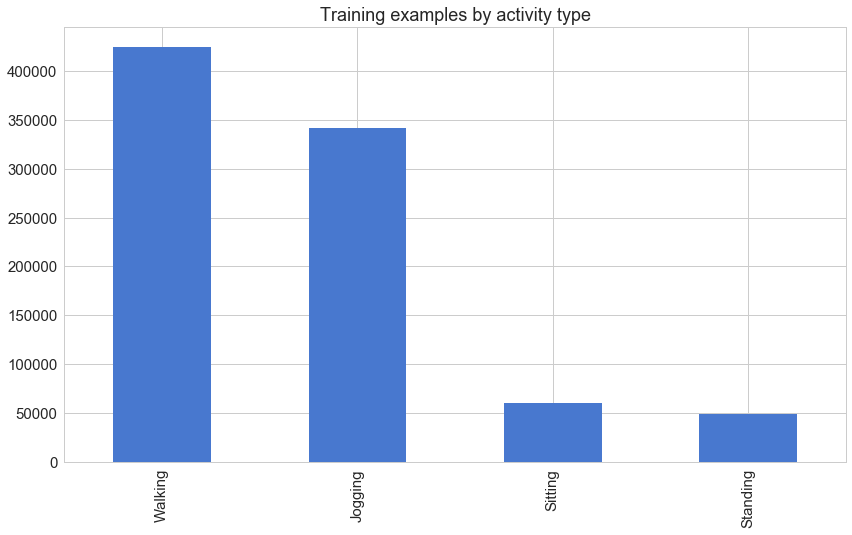

In [8]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

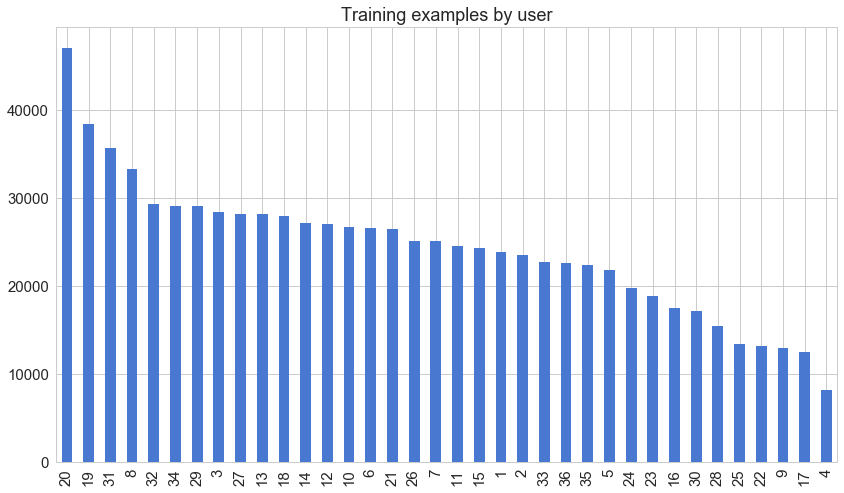

In [9]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [10]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

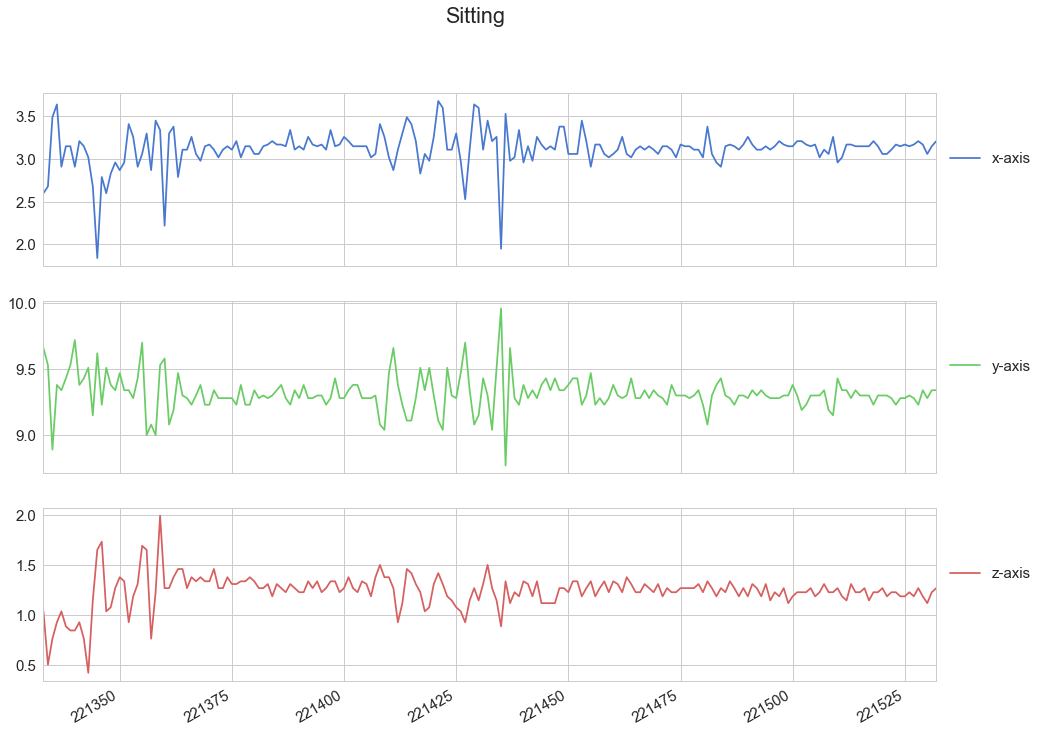

In [11]:
plot_activity("Sitting", df)

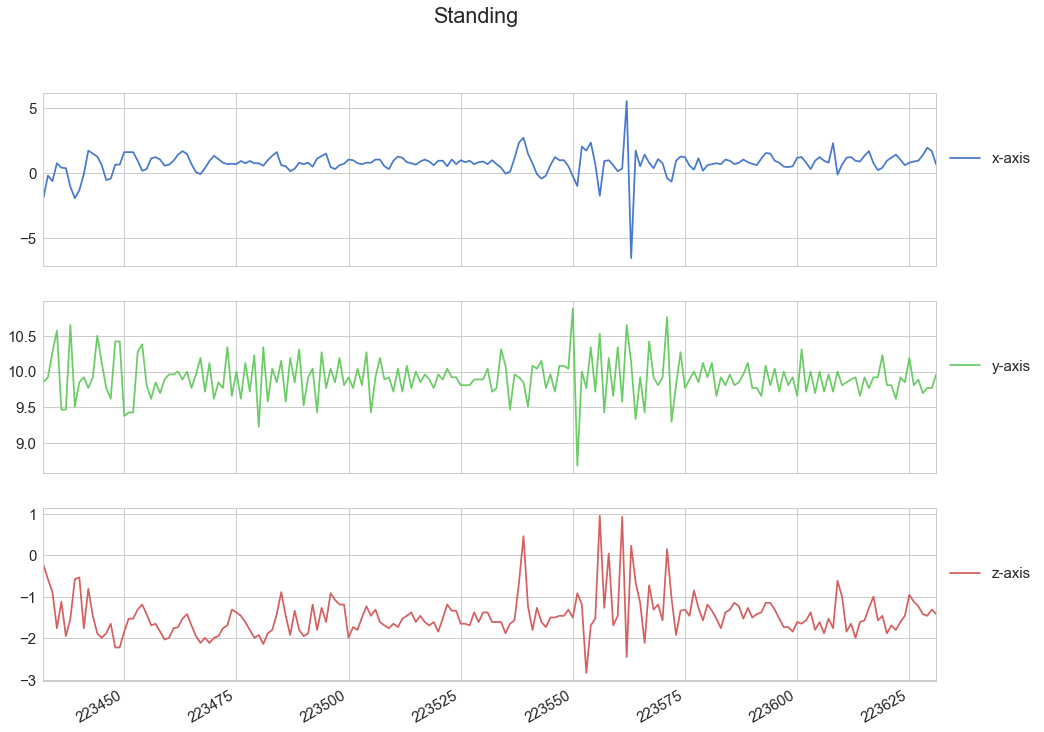

In [12]:
plot_activity("Standing", df)

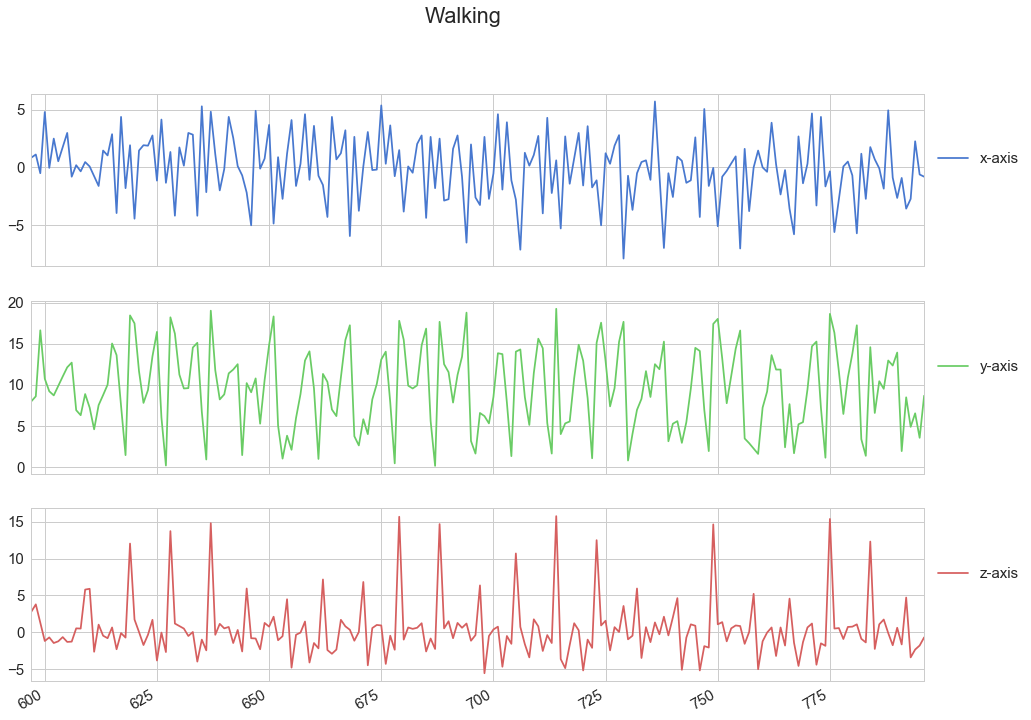

In [13]:
plot_activity("Walking", df)

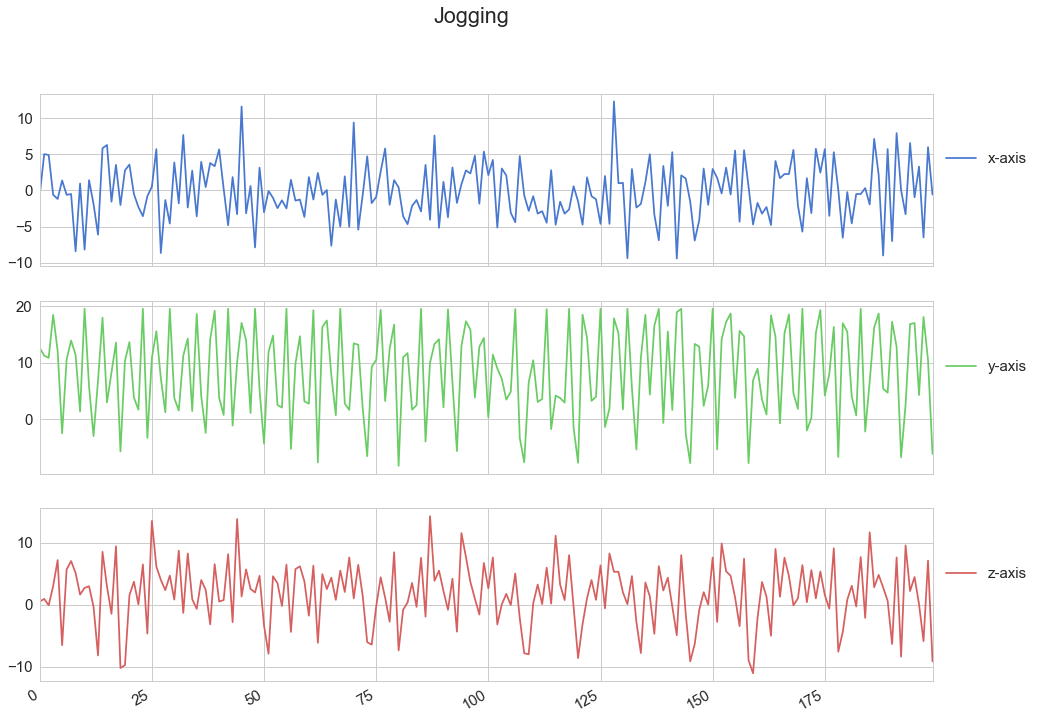

In [14]:
plot_activity("Jogging", df)

# Data preprocessing

In [66]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

/Users/gajel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [67]:
np.array(segments).shape

(43736, 3, 200)

In [68]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [69]:
reshaped_segments.shape

(43736, 200, 3)

In [74]:
labels[0]

array([ 1.,  0.,  0.,  0.], dtype=float32)

## Training and test sets

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [76]:
print(len(X_train))
print(len(y_train))
print(X_train.shape)
print(X_train[1][1:10])

34988
34988
(34988, 200, 3)
[[  6.21000004   7.3499999    5.17999983]
 [  5.86000013   0.34        -4.36999989]
 [-16.31999969 -12.72000027  -0.19      ]
 [  8.19999981  13.02000046   5.63000011]
 [  7.3499999    5.09000015  -1.99000001]
 [ -4.32999992   8.35000038   6.13000011]
 [  4.13999987   2.41000009  -5.40999985]
 [-10.11999989 -16.59000015  -6.92999983]
 [  0.56999999  12.86999989  11.32999992]]


In [77]:
len(X_test)

8748

# Building the model

 - 2 fully-connected
 - 2 LSTM layers

In [78]:
N_CLASSES = 4
N_HIDDEN_UNITS = 64

In [79]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [80]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [81]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [82]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [83]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# Training

In [84]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [85]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    #if i != 1 and i % 10 != 0:
    #    continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

epoch: 1 test accuracy: 0.8917466998100281 loss: 0.9375183582305908
epoch: 2 test accuracy: 0.9673067927360535 loss: 0.7167302370071411
epoch: 3 test accuracy: 0.9775948524475098 loss: 0.6445748209953308
epoch: 4 test accuracy: 0.9726794958114624 loss: 0.636545717716217
epoch: 5 test accuracy: 0.9798811078071594 loss: 0.5813899040222168
epoch: 6 test accuracy: 0.9774805903434753 loss: 0.5685121417045593
epoch: 7 test accuracy: 0.978738009929657 loss: 0.546384871006012
epoch: 8 test accuracy: 0.986968457698822 loss: 0.49920737743377686
epoch: 9 test accuracy: 0.9897119402885437 loss: 0.47249796986579895
epoch: 10 test accuracy: 0.986968457698822 loss: 0.4565671682357788
epoch: 11 test accuracy: 0.9905121326446533 loss: 0.432944655418396
epoch: 12 test accuracy: 0.986968457698822 loss: 0.4206904470920563
epoch: 13 test accuracy: 0.9929126501083374 loss: 0.393708199262619
epoch: 14 test accuracy: 0.992226779460907 loss: 0.3791421055793762
epoch: 15 test accuracy: 0.9913123250007629 loss: 

In [98]:
pickle.dump(predictions, open("pickle/predictions.p", "wb"))
pickle.dump(history, open("pickle/history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')  
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

In [99]:
history = pickle.load(open("pickle/history.p", "rb"))
predictions = pickle.load(open("pickle/predictions.p", "rb"))

# Evaluation

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [89]:
LABELS = ['Jogging', 'Sitting', 'Standing', 'Walking']

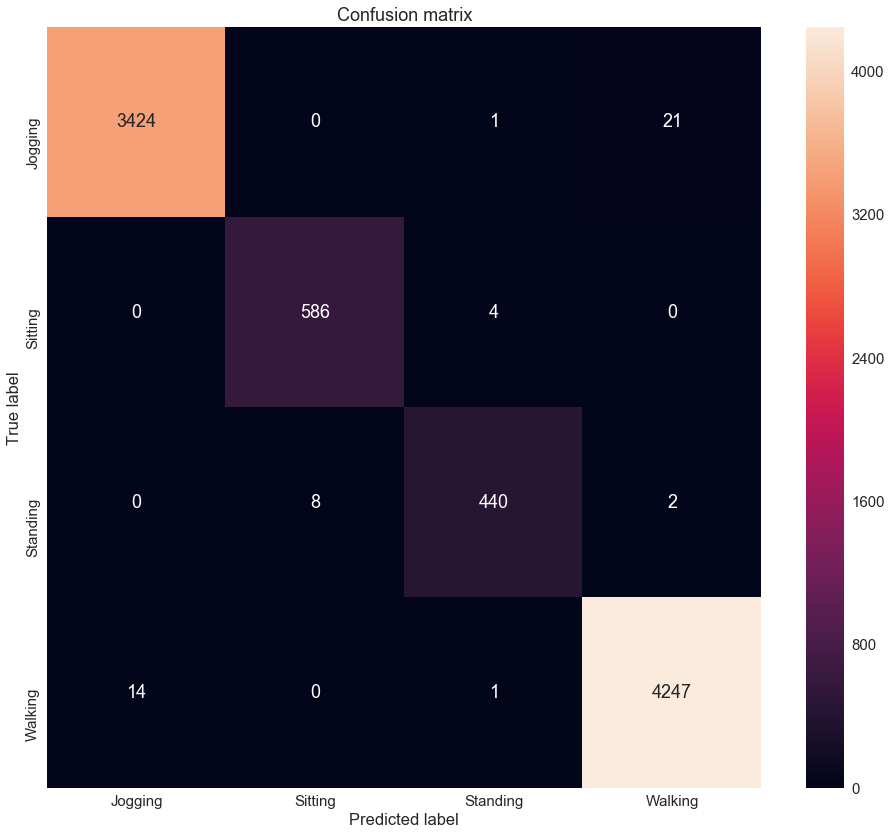

In [90]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Export the model

In [101]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'models/frozen_'+MODEL_NAME+'_4.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0", 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
